# Experiment: Model with 3 classes (clean, damaged, dirt)

## Unbalaced classes

In [1]:
#load images
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
import matplotlib.pyplot as plt 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from PIL import Image
import os
%matplotlib inline

2023-08-31 12:15:20.984320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 12:15:21.117079: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 12:15:21.118152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 12:15:22.618200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
batch_size = 32
train_data_dir = "raw_data/exp2-training-data-balanced/"
test_data_dir = "raw_data/exp2-val-data-balanced/"

train_data = image_dataset_from_directory(
  train_data_dir,
  #labels = "inferred",
  label_mode = "int",  
  seed=123,
  image_size=(225, 225),
  batch_size=batch_size,
  #validation_split=0.2,
  #subset='both'
) 
val_data = image_dataset_from_directory(
   test_data_dir,
   #labels = "inferred",
   label_mode = "int",
   seed=123,
   image_size=(225, 225),
   batch_size=batch_size,
 )

#train_data = train_ds[0]
#val_data = train_ds[1]

Found 399 files belonging to 3 classes.
Found 90 files belonging to 3 classes.


In [4]:
classes1 = train_data.class_names
classes1

['clean', 'damage', 'dirt']

In [5]:
classes2 = val_data.class_names
classes2

['clean', 'damage', 'dirt']

In [8]:
import os
current_path = os.getcwd()
print(current_path)
test_data_dir = os.path.join(current_path,"..", "raw_data/exp2-val-data-balanced/dirt")
print(test_data_dir)
# Specify the directory path you want to list files in
directory = test_data_dir

# List all files in the directory
file_list = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Print the list of files
for file in file_list:
    print(file)


/home/emiliamelo/code/meloeckert/solar_project/notebooks
/home/emiliamelo/code/meloeckert/solar_project/notebooks/../raw_data/exp2-val-data-balanced/dirt
Dust (152).jpeg
Bird (72).jpeg
Bird (64).jpeg
Dust (71).jpeg
Bird (56).jpeg
Bird (18).jpeg
Dust (8).jpeg
Bird (117).jpeg
Dust (117).jpeg
Dust (47).jpeg
Dust (53).jpeg
Bird (21).jpeg
Bird (90).jpeg
Bird (29).jpeg
Dust (136).jpeg
Bird (12).jpeg
Dust (147).jpeg
Dust (135).jpeg
Bird (115).jpeg
Bird (34).jpeg
Dust (25).jpeg
Bird (36).jpeg
Dust (24).jpeg
Dust (62).jpeg
Bird (105).jpeg
Dust (14).jpeg
Bird (86).jpeg
Dust (83).jpeg
Dust (37).jpeg
Bird (102).jpeg


### Model

In [6]:
# We'll use a model with the same convolutional layers, but we'll add Augmentation layers before that

model_multi = Sequential()

model_multi.add(layers.Rescaling(1./255, input_shape = (225, 225, 3)))

# Data Augmentation Layers

model_multi.add(layers.RandomFlip("horizontal"))
model_multi.add(layers.RandomZoom(0.1))
model_multi.add(layers.RandomTranslation(0.2, 0.2))
model_multi.add(layers.RandomRotation(0.1))


# Convolutional Layers

model_multi.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_multi.add(layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_multi.add(layers.Conv2D(filters = 64, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_multi.add(layers.Conv2D(filters = 128, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_multi.add(layers.Flatten())

model_multi.add(layers.Dense(64, activation="relu"))

model_multi.add(layers.Dropout(0.5))

model_multi.add(layers.Dense(3, activation="softmax"))

In [7]:
model_multi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 225, 225, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 225, 225, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 225, 225, 3)       0         
                                                                 
 random_translation (Random  (None, 225, 225, 3)       0         
 Translation)                                                    
                                                                 
 random_rotation (RandomRot  (None, 225, 225, 3)       0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 32)      8

In [8]:
adam = optimizers.Adam(learning_rate = 0.001)

model_multi.compile(loss= SparseCategoricalCrossentropy(),
              optimizer= adam,
              metrics=['accuracy'])

In [9]:
MODEL = "model_multiclass_clean_damage_dirt_310823_v2_self_balanced"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [10]:
#new weights - remove snow images, and macro pic of bird
clean = 133
damage = 133
dirt = 133
total = clean + damage + dirt
print(f'total: {total}')
clean_weight =  (clean/total)**-1
damage_weight = (damage/total)**-1
dirt_weight = (dirt/total)**-1
print(f"clean weight: {clean_weight}")
print(f"damage weight: {damage_weight}")
print(f"dirt weight: {dirt_weight}")

total: 399
clean weight: 3.0
damage weight: 3.0
dirt weight: 3.0


In [11]:
%%time
#'clean', 'damage', 'dirt'
history_multi = model_multi.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper],
        class_weight = {
            0: 3.0,
            1: 3.0,
            2: 3.0
        }
        )


Epoch 1/30
13/13 [==============================] - 17s 1s/step - loss: 3.7339 - accuracy: 0.3283 - val_loss: 1.0945 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/30


/home/emiliamelo/.pyenv/versions/3.10.6/envs/solar_project/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 16s 1s/step - loss: 3.2601 - accuracy: 0.3358 - val_loss: 1.0844 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/30
13/13 [==============================] - 16s 1s/step - loss: 3.1895 - accuracy: 0.4637 - val_loss: 1.0535 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/30
13/13 [==============================] - 17s 1s/step - loss: 3.2376 - accuracy: 0.4486 - val_loss: 1.0821 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 5/30
13/13 [==============================] - 18s 1s/step - loss: 3.1715 - accuracy: 0.4561 - val_loss: 1.0129 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/30
13/13 [==============================] - 18s 1s/step - loss: 3.0671 - accuracy: 0.5213 - val_loss: 0.9918 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/30
13/13 [==============================] - 18s 1s/step - loss: 2.8770 - accuracy: 0.5689 - val_loss: 0.9523 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 8/30
13/13 [==============================] - 18s 1s/step - loss: 2.9282 - accuracy: 0.

In [ ]:
#improvement = (0.51 - (1/3))/(1/3)
#improvement

In [12]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

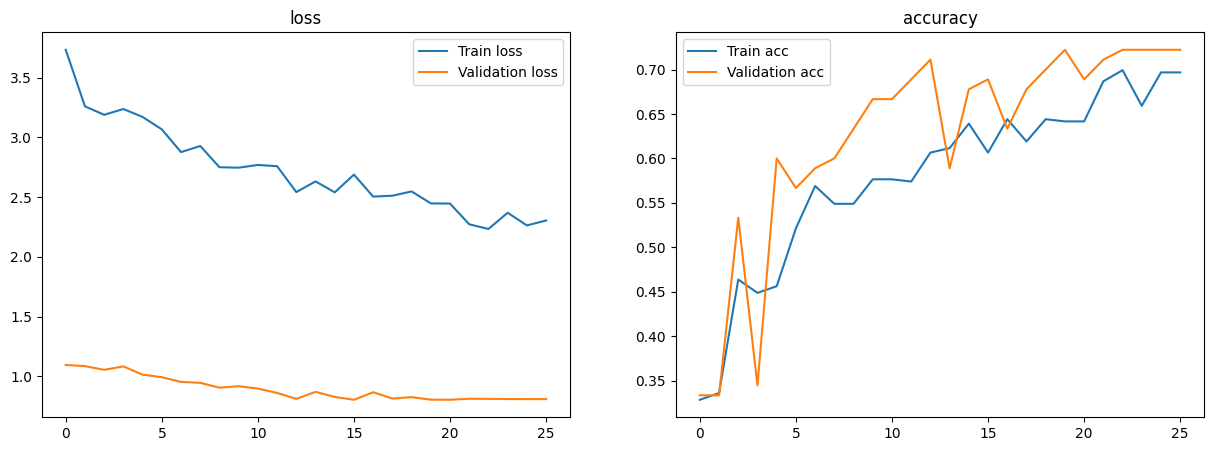

In [13]:
plot_history(history_multi)

### Helper functions

In [14]:
def find_index_of_max_element(input_list):
    max_value = max(input_list)
    max_index = input_list.index(max_value)
    return max_index

In [15]:
def predictImage_multiclass(url, model):

  # Takes an image and a model

  img = url
  img = img_to_array(img)
  img = img.reshape((-1, 225, 225, 3))
  res = model.predict(img)
  print(f"Probabilities: ")
  names_of_classes = class_names
  print(f"{names_of_classes}")
  print(f"{res[0]}")
  print(f"Result: {names_of_classes[find_index_of_max_element(res[0].tolist())]}")  
  return res 

In [ ]:
# img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (4).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_clean_1,model_multi)
# plt.imshow(img_clean_1);

In [ ]:
# img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (12).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_clean_1,model_multi)
# plt.imshow(img_clean_1);

In [ ]:
# img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (21).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_clean_1,model_multi)
# plt.imshow(img_clean_1);

### Snow

In [ ]:
# img_snow = load_img(f"raw_data/training-data/solar/Solar (3).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_snow,model_multi)
# plt.imshow(img_snow);

In [ ]:
# img_snow = load_img(f"raw_data/training-data/solar/Solar (12).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_snow,model_multi)
# plt.imshow(img_snow);

In [ ]:
# img_snow = load_img(f"raw_data/training-data/solar/Solar (33).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_snow,model_multi)
# plt.imshow(img_snow);

### Damage

In [ ]:
# img_electrical = load_img(f"raw_data/training-data/electrical/Electrical (29).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_electrical,model_multi)
# plt.imshow(img_electrical);

In [ ]:
# img_physical = load_img(f"raw_data/training-data/physical_damaged/Physical-damaged (37).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_physical,model_multi)
# plt.imshow(img_physical);

In [ ]:
# img_physical = load_img(f"raw_data/training-data-exp/damage/Electrical (23).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_physical,model_multi)
# plt.imshow(img_physical);

### Bird or dust


In [ ]:
##pics bird 37,55,59,  --> macro pic on brid drop --> predicting wrong class
# pic 65
# img_physical = load_img(f"raw_data/training-data/bird/Bird (65).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_physical,model_multi)
# plt.imshow(img_physical);

In [ ]:
# img_physical = load_img(f"raw_data/training-data/bird/Bird (5).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_physical,model_multi)
# plt.imshow(img_physical);

In [ ]:
#img_physical = load_img(f"raw_data/training-data-exp/dirt/Bird (47).jpeg", target_size=(225, 225))
#predictImage_multiclass(img_physical,model_multi)
#plt.imshow(img_physical);

In [16]:
def predictImage_multiclass(url, model):

  # Takes an image and a model

  img = url
  img = img_to_array(img)
  img = img.reshape((-1, 225, 225, 3))
  res = model.predict(img)
  print(f"Probabilities: ")
  names_of_classes = ['clean','damaged','dirty']
  print(f"{names_of_classes}")
  print(f"{res[0]}")
  print(f"Result: {names_of_classes[find_index_of_max_element(res[0].tolist())]}")  
  return res 

In [17]:
import numpy as np
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report


predictions = np.array([])
print(predictions.shape)
labels =  np.array([])
for x, y in val_data:
    
  pred = model_multi.predict(x)
  pred = np.argmax(pred, axis=-1)
  print(f"pred {pred.shape}")
  predictions = np.concatenate([predictions, pred ])
  label =  np.argmax(y.numpy(), axis=-1)
  print(f"label shape {label.shape}")
  labels = np.concatenate([labels, y])  #np.argmax(y.numpy()

report = classification_report(labels, predictions, target_names=classes1)

print(report)

(0,)
1/1 [==============================] - 0s 329ms/step
pred (32,)
label shape ()
1/1 [==============================] - 0s 194ms/step
pred (32,)
label shape ()
1/1 [==============================] - 0s 207ms/step
pred (26,)
label shape ()
              precision    recall  f1-score   support

       clean       0.69      0.83      0.76        30
      damage       0.77      0.57      0.65        30
        dirt       0.62      0.67      0.65        30

    accuracy                           0.69        90
   macro avg       0.70      0.69      0.69        90
weighted avg       0.70      0.69      0.69        90



In [18]:
confusion_matrix(labels=labels, predictions=predictions).numpy()


array([[25,  1,  4],
       [ 5, 17,  8],
       [ 6,  4, 20]], dtype=int32)

## Test data

In [ ]:
# batch_size = 8
# test_data_dir = "raw_data/exp-test-data/"

# test_data = image_dataset_from_directory(
#   test_data_dir,
#   #labels = "inferred",
#   label_mode = "int",  
#   seed=123,
#   image_size=(225, 225),
#   batch_size=batch_size,
# ) 


In [ ]:
# predictions = np.array([])
# print(predictions.shape)
# labels =  np.array([])
# for x, y in test_data:
    
#   pred = model_multi.predict(x)
#   pred = np.argmax(pred, axis=-1)
#   print(f"pred {pred.shape}")
#   predictions = np.concatenate([predictions, pred ])
#   label =  np.argmax(y.numpy(), axis=-1)
#   print(f"label shape {label.shape}")
#   labels = np.concatenate([labels, y])  #np.argmax(y.numpy()

# report = classification_report(labels, predictions, target_names=classes1)

# print(report)

In [ ]:
confusion_matrix(labels=labels, predictions=predictions).numpy()

In [19]:
import numpy as np
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report

In [69]:
predictions = np.array([])
probabilities_clean = np.array([])
labels =  np.array([])

for x, y in val_data:
    
  prediction_array = model_multi.predict(x)
  probability_clean = prediction_array
  #probability_clean = np.squeeze(probability_clean)  
  #print(f'prob clean: {probability_clean}')  
  probabilities_clean = np.append(probabilities_clean, probability_clean)
    
  pred = np.argmax(prediction_array, axis=-1)

  predictions = np.concatenate([predictions, pred ])

  labels = np.concatenate([labels, y])  #np.argmax(y.numpy()

report = classification_report(labels, predictions, target_names=classes1)

print(report)
reshaped_array = probabilities_clean.reshape(-1, 3)


1/1 [==============================] - 0s 203ms/step
              precision    recall  f1-score   support

       clean       0.69      0.83      0.76        30
      damage       0.77      0.57      0.65        30
        dirt       0.62      0.67      0.65        30

    accuracy                           0.69        90
   macro avg       0.70      0.69      0.69        90
weighted avg       0.70      0.69      0.69        90



In [26]:
from sklearn.metrics import precision_recall_curve
import pandas as pd

In [28]:
precision, recall, threshold = precision_recall_curve(labels, probabilities_clean)
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]}) # Store in a dataframe
scores

ValueError: multiclass format is not supported

In [ ]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [ ]:
new_threshold = scores[scores['precision'] >= 0.4].threshold.min()
new_threshold

In [96]:
def custom_predict(X, custom_threshold, model):
    probability = model.predict(X) # Get likelihood of each sample being classified as 0 or 1
    proba_clean = 1- probability[:,-1]
    #print(modified_array)
    #more_5y_probs = probability[:, 1] # Only keep expensive likelihoods (1) 
    return (proba_clean > custom_threshold).astype(int) # Boolean outcome converted to 0 or 1

pred_thres = np.array([])

for x, y in val_data:    
    updated_preds = custom_predict(X=x, custom_threshold=0.6, model=model_multi) # Update prediction
    updated_preds = np.squeeze(updated_preds)
    pred_thres = np.concatenate([pred_thres, updated_preds])

1/1 [==============================] - 0s 143ms/step


In [82]:
labels.shape

(90,)

In [92]:
pred_thres.shape

(90,)

In [99]:
confusion_matrix(labels=labels, predictions=pred_thres).numpy()

array([[ 8, 22,  0],
       [ 9, 21,  0],
       [11, 19,  0]], dtype=int32)

In [ ]:
report = classification_report(labels, pred_thres, target_names=class_names)

print(report)

In [75]:
from sklearn.metrics import classification_report
import numpy as np
print(f'labels shape: {labels.shape}')
# Assuming 'probs' is the predicted probabilities for each class
# 'thresholds' is a list of chosen thresholds for each class
thresholds = [0.8, 0.8, 0.8]

probs = reshaped_array
print(len(reshaped_array[:,0]))
# Apply threshold adjustment
adjusted_predictions = []
labels_matrix = []
for j, label in zip(range(len(probs[:,0])),labels):
    prob_element = probs[j,:]
    #print(f'prob_element: {prob_element}')
    #for i in range(len(prob_element)):
    adjustment = [1 if p >= thresholds[c] else 0 for c, p in enumerate(prob_element)]
    labels_mat = [1 if label==c else 0 for c, l in enumerate(range(len(prob_element)))]
    #print(f'labels_mat: {labels_mat}, label: {label}')
    #print(f"adjustment: {adjustment}")
    #adjustment = np.argmax(adjustment, axis=-1)
    adjusted_predictions.append(adjustment)
    labels_matrix.append(labels_mat)
# Convert to NumPy array
adjusted_predictions = np.array(adjusted_predictions)
labels_matrix = np.array(labels_matrix)
print(f'adjust pred: {adjusted_predictions.shape}')

# Assuming 'labels' is the ground truth labels
class_names = ['class_1', 'class_2', 'class_3']

#labels = 
print(f'labels_matrix shape: {labels_matrix.shape}')
# Generate classification report for each class
for c in range(len(class_names)): #range(len(labels)): #
    print(f"Metrics for {class_names[c]}:")
    class_labels = labels_matrix[:, c]  # Extract labels for the current class   # c 
    class_predictions = adjusted_predictions[:, c]  # Extract adjusted predictions for the current class
    report = classification_report(class_labels, class_predictions)
    print(report)


labels shape: (90,)
90
adjust pred: (90, 3)
labels_matrix shape: (90, 3)
Metrics for class_1:
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        60
           1       1.00      0.27      0.42        30

    accuracy                           0.76        90
   macro avg       0.87      0.63      0.63        90
weighted avg       0.82      0.76      0.70        90

Metrics for class_2:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        60
           1       0.00      0.00      0.00        30

    accuracy                           0.67        90
   macro avg       0.33      0.50      0.40        90
weighted avg       0.44      0.67      0.53        90

Metrics for class_3:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        60
           1       0.00      0.00      0.00        30

    accuracy                           0.67   

/home/emiliamelo/.pyenv/versions/3.10.6/envs/solar_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emiliamelo/.pyenv/versions/3.10.6/envs/solar_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/emiliamelo/.pyenv/versions/3.10.6/envs/solar_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [65]:
prediction_array = np.array([0.3, 0.4,0.3])
pred = np.argmax(prediction_array, axis=-1)
pred

1